## KrSTC passivated surface pulse shape analysis

C. Wiseman, written for CAGE/KrSTC sw stack

We saw a promising Kr signal in Run 41, but then temperature-cycled the detector and lost the signal (Runs 46, 51).

Here, I want to look at the waveform rise time and T/E parameters to try and isolate the surface event population.   
They should have a faster rise time like the 60 keV events we saw in CAGE.

In [14]:
import sys
utils_path = '/global/homes/f/fnafis/utils_nf/'
if utils_path not in sys.path:
    sys.path.append(utils_path)
import legend_utils_nf as lutils

In [1]:
legend_ana_dir = '/global/cfs/cdirs/legend/software/KrSTC/data/analysis'
legend_data_dir = '/global/cfs/cdirs/legend/software/KrSTC/data'



import os, h5py, json, copy
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.style.use(legend_data_dir+'/clint.mpl')

from pygama.flow import DataGroup
from pygama.lgdo.lh5_store import load_nda, LH5Store
import pygama.math.histogram as pgh
from pygama.lgdo import ls, load_dfs
from pygama.dsp import build_dsp
from pygama.vis import WaveformBrowser

import pint
ureg = pint.UnitRegistry()

import pygama.lgdo.lh5_store as lh5
import pygama.math.histogram as pgh



## Single-file analysis

Set the query here to DataGroup to load files.  You may want to refer to `runDB.json` to see how to vary this.  Here we also set the energy parameter of interest. 

In [22]:
f = h5py.File('/global/cfs/cdirs/legend/software/KrSTC/data/fileDB.h5', 'r')
g = f['file_keys']
h = g['block3_items'][:]
# print full list of h
h[0:10]

array([b'daq_dir', b'daq_file', b'runtype', b'unique_key', b'raw_file',
       b'raw_path', b'dsp_file', b'dsp_path', b'hit_file', b'hit_path'],
      dtype='|S10')

In [18]:
g.keys()

<KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values', 'block1_items', 'block1_values', 'block2_items', 'block2_values', 'block3_items', 'block3_values']>

In [2]:
# fileDB query
que = 'cycle==2665' # kr for sure!  From Campaign 6 
#use 2604-2640 for bkg run in campaign 6
#que = 'cycle==2635'

# decay run
#"42":["2679-2728", "bkg", "2023/02/17 closed the kr valve at 11am and ran overnight.  elog 615"],

# energy estimator of interest
etype = 'energy'
# etype = 'trapEftp'
# etype = 'trapEmax'

# lh5 table name
tb_in = 'ORSIS3302DecoderForEnergy/raw'

# load the fileDB and make sure the entries exist
dg = DataGroup(legend_data_dir+'/krstc.json', load=True)
dg.fileDB.query(que, inplace=True)

ecal_cols = ['run', 'cycle', 'skip', 'runtype', 'startTime', 'threshold', 'stopTime', 'runtime']
dg.fileDB[ecal_cols]

KeyError: "['startTime', 'threshold', 'stopTime', 'runtime'] not in index"

## Check raw spectrum

Take a quick look at the raw energy spectrum.  I could compute a rough energy calibration as in `energy_raw.ipynb` if I wanted to carefully select energies from a particular peak, to look at their waveforms.  But since I'll have a DSP file in a few steps I don't really need to do that yet.


LH5 columns: ['card', 'channel', 'crate', 'energy', 'energy_first', 'packet_id', 'timestamp', 'waveform']

Raw E: energy, 121896 cts, runtime: 28.34 min
Low-E counts:  75636


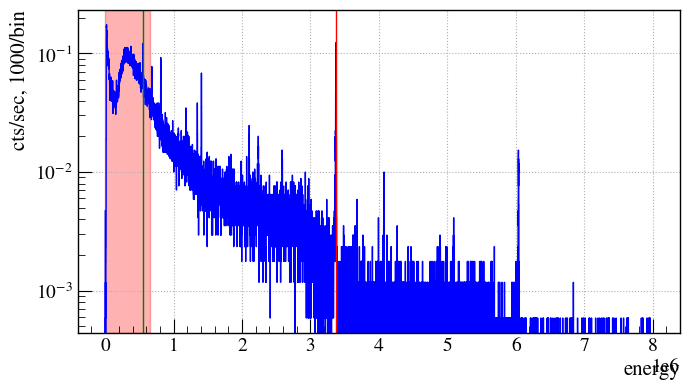

In [10]:
# essentially the same code as in energy_cal::check_raw_spectrum

# load numpy arrays of uncalibrated energy
raw_list = dg.lh5_dir + dg.fileDB['raw_path'] + '/' + dg.fileDB['raw_file']
raw_data = load_nda(raw_list, [etype], tb_in)

# get runtime
runtime_min = dg.fileDB['runtime'].sum()

# print columns of table
with h5py.File(raw_list.iloc[0], 'r') as hf:
    print('\nLH5 columns:', list(hf[f'{tb_in}'].keys()))
    
# draw a few lines in the uncalibrated spectrum, 
# and select the part we want to run DSP on.
    
# histogram energy data for this estimator and normalize by runtime
data = raw_data[etype]
print(f'\nRaw E: {etype}, {len(data)} cts, runtime: {runtime_min:.2f} min')

# uncalibrated energy range
xlo, xhi, xpb = 0, 8e6, 1000
# xlo, xhi, xpb = 0, 10000, 10  # good for trapEmax and trapEftp
# xlo, xhi, xpb = 0, 1000, 1 # low-e region

# set energy range to run DSP
e_proc_lo, e_proc_hi = 0, 5.515e5 * 1.2

# optional: apply a cut
data = data[(data >= xlo) & (data <= xhi)]

# histogram
hist, bins, var = pgh.get_hist(data, range=(xlo, xhi), dx=xpb)
hist_rt = np.divide(hist, runtime_min * 60)

# plot
#%matplotlib widget
fig = plt.figure(figsize=(7,4))
fig.canvas.header_visible = False

plt.semilogy(bins[1:], hist_rt, ds='steps', c='b', lw=1, label=etype)

# campaign 6
plt.axvline(3.37450e6, c='r', lw=1) # 1460 keV
plt.axvline(5.515e5, c='g', lw=1) # 238 keV

plt.axvspan(0, e_proc_hi, color='red', alpha=0.3)

n_cts_lowe = np.sum(hist[bins[1:] < e_proc_hi])
print('Low-E counts: ', n_cts_lowe)

plt.xlabel(etype, ha='right', x=1)
plt.ylabel(f'cts/sec, {xpb}/bin', ha='right', y=1)
plt.tight_layout()
plt.show()


## Check waveforms

Make a `WaveformBrowser` to check that the pole-zero and energy trapezoid values are reasonable.
I could maybe calculate some values and update them in the "db" dictionary associated with every config file.

Reference: https://pygama.readthedocs.io/en/stable/notebooks/WaveformBrowser.html

/global/cfs/cdirs/m2676/data/krstc/LH5/raw/krstc_run41_cyc2665_raw.lh5


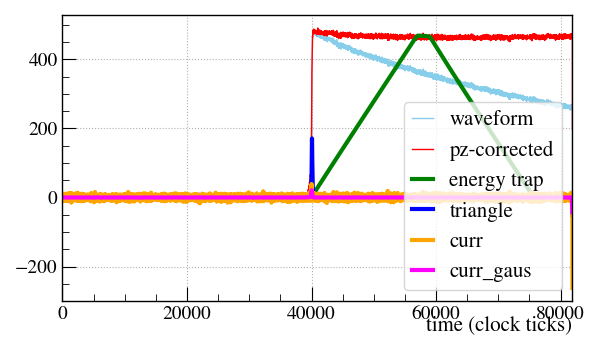

In [4]:
# load first file 
raw_list = dg.lh5_dir + dg.fileDB['raw_path'] + '/' + dg.fileDB['raw_file']
f_raw = raw_list.iloc[0]
print(f_raw)

ix_lowe = np.where((data >= 0) & (data <= e_proc_hi))
entry_no = ix_lowe[0][60]

# build the first version of this by eye & feed back into the config file.
# Weirdly, this seems to require a different format than build_dsp, at least in pygama 1.1.0
wfb_db = {
    # 'baseline_slice': 'waveform[:1000]', # this one works for WB but not build_dsp
    'pz':{'tau': '71.7*us'}, 
    'etrap':{'rise':'16.98*us', 'flat':'2*us'},
    # 'ttrap':{'rise':'100*ns', 'flat':'10*ns'} # default
    'ttrap':{'rise':'50*ns', 'flat':'10*ns'}, # experiment
    'dcr_trap':{'rise':'6.2*us', 'flat':'20.1*us'},
    'dcr':{'ftp': '80*us'},
    }

browser = WaveformBrowser(f_raw, tb_in, 
                          dsp_config=legend_ana_dir+'/dsp_default_db.json',
                          database=wfb_db,
    lines=['wf_blsub', 'wf_pz', 'wf_trap', 'wf_triangle', 'curr', 'curr_gaus'],
    styles=[
        {'color': ['skyblue'], 'lw':[1]},
        {'color': ['r'], 'lw':[1]},
        {'color': ['g']},
        {'color': ['b']},
        {'color': ['orange']},
        {'color': ['magenta']},
    ],
    legend=['waveform', 'pz-corrected', 'energy trap', 'triangle', 'curr', 'curr_gaus']
            # "E = {trapEmax}"]
    # x_lim=('40*us', '71.7*us'),
)

%matplotlib widget
fig, ax = plt.subplots(figsize=(6,3.5))
fig.canvas.header_visible = False
browser.fig = fig
browser.ax = ax

browser.draw_entry(entry_no)

# ax.set_xlim(39000, 42000)
ax.set_xlabel('time (clock ticks)', ha='right', x=1) # can't set x-label pad?
plt.tight_layout()

# note: I can pull out all data from the WB with the following:
# browser.find_next()
# waveforms = browser.lines["waveform"]
# traps = browser.lines["wf_trap"]
# energies = browser.legend_vals["trapEmax"]
# for wf, trap, en in zip(waveforms, traps, energies):
#     print("Raw waveform:", wf.get_ydata())
#     print("Trap-filtered waveform:", trap.get_ydata())
#     print("TrapEmax:", en)
#     print()


## Test DSP

Load the raw file and create an entry list, and run dsp.  
Eventually, I don't want to make a temporary copy of my file (the way the pygama examples suggest),
I want this to run in-memory in the notebook.
But for now, it's much simpler to just call `build_dsp` and do the cut on the output file.

Reference: https://github.com/legend-exp/pygama/blob/main/src/pygama/dsp/build_dsp.py


In [15]:
# run DSP on one file

# dsp_list = dg.lh5_dir + dg.fileDB['dsp_path'] + '/' + dg.fileDB['dsp_file']
dsp_list = dg.fileDB['dsp_file']
f_dsp = dsp_list.iloc[0]

# declare the parameter DB.  Weirdly, requires a different format than the WaveformBrowser
dsp_db = {tb_in: wfb_db}
print(dsp_db)

# you might want to only run the DSP if the file doesn't already exist (takes several minutes)
# if not os.path.exists(f_dsp):
# build_dsp(f_raw, f_dsp,
#     dsp_config=legend_ana_dir+'/dsp_default_db.json',
#     database=dsp_db,
#     write_mode="r",
# )

NameError: name 'wfb_db' is not defined

In [6]:
!ls -lh /global/cfs/cdirs/m2676/data/krstc/LH5/raw/krstc_run41_cyc2665_raw.lh5
!ls -lh krstc_run41_cyc2665_dsp.lh5

-rw-r--r-- 1 61535 legend 1.9G Feb 17 10:51 /global/cfs/cdirs/m2676/data/krstc/LH5/raw/krstc_run41_cyc2665_raw.lh5
-rw-r--r-- 1 fnafis fnafis 21M Apr 11 16:26 krstc_run41_cyc2665_dsp.lh5


Load the DSP file and double-check the `dsp_db` constants were applied correctly.

In [16]:
#show(f_dsp)
# show(f_raw)

store = LH5Store()
tb_dsp = tb_in.replace('/raw','/dsp')
obj, nrows = store.read_object(tb_dsp, f_dsp)
df_dsp = obj.get_dataframe()
display(df_dsp)

# check version of pygama used to make the DSP file
lh5_file = store.gimme_file(f_dsp, "r")
# print(lh5_file['dsp_info'].attrs())
grp = ls(f_dsp, 'dsp_info/pygama_version')[0]

print('NOTE: pygama version is:', lh5_file[grp][...])

# don't need to make a plot, just test we get the same DSP values between the 
# WaveformBrowser and the build_dsp function.
# this tests that we correctly loaded the parameter DB for the pz and trap consts, which can be finicky.

with open(legend_ana_dir+'/dsp_default_db.json') as f:
    test_config = json.load(f)
    dsp_cols = test_config['outputs']

wb2 = WaveformBrowser(f_raw, tb_in, 
    dsp_config = legend_ana_dir+'/dsp_default_db.json',
    database = dsp_db,
    lines = ['wf_blsub', 'wf_pz', 'wf_trap'],
    legend = [f'{{{col}}}' for col in dsp_cols], # get all output cols
)
wb2.clear_data()
wb2.find_entry(entry_no)
wfs = wb2.lines 
wb_vals = wb2.legend_vals # dict w/ "pint" values w/ number & units
wb2_vals = pd.Series({k: v[0].magnitude for k, v in wb_vals.items()})

# now check our DSP file
dsp_vals = df_dsp.iloc[entry_no]

# print(dsp_vals)
assert dsp_vals.to_dict() == wb2_vals.to_dict(), "DSP values must match by entry!"

,timestamp,channel,energy,bl,bl_sig,bl_slope,bl_intercept,trapEmax,trapTmax,ftp,...,wf_max,tp_0,tp_02,tp_05,tp_10,tp_20,tp_50,tp_90,tp_96,dcr
0,3935366,7,574488,33792.437500,3.825263,-0.000713,33792.781250,612.929077,48090.0,49274.0,...,649.562500,39530.0,39590.0,39670.0,39790.0,39930.0,40000.0,40100.0,40150.0,-111.778679
1,4011966,7,1131209,33873.269531,3.688638,-0.001839,33874.160156,1206.998901,48280.0,49064.0,...,1276.730469,39320.0,39610.0,39790.0,39950.0,40110.0,40190.0,40290.0,40350.0,-221.000015
2,4673942,7,63370,33790.109375,3.682739,-0.000706,33790.410156,67.286026,47540.0,48324.0,...,78.890625,38580.0,39200.0,39390.0,39390.0,39410.0,39460.0,41250.0,41250.0,-12.036266
3,6328771,7,1019395,33774.812500,3.607840,-0.001135,33775.445312,1087.540771,48260.0,49214.0,...,1151.187500,39470.0,39560.0,39740.0,39910.0,40070.0,40150.0,40260.0,40310.0,-201.968872
4,7474514,7,784277,33779.832031,3.700096,-0.000126,33779.917969,836.523865,48160.0,49204.0,...,886.167969,39460.0,39510.0,39630.0,39830.0,39980.0,40060.0,40170.0,40230.0,-153.222443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121891,170012324470,7,39662,33782.761719,3.612764,-0.001678,33783.632812,42.175980,47170.0,48394.0,...,53.238281,38650.0,38950.0,38990.0,39000.0,39070.0,39110.0,40330.0,40330.0,-9.574835
121892,170012337759,7,667216,33794.671875,3.740687,-0.000986,33795.144531,712.000671,48180.0,49114.0,...,744.328125,39370.0,39530.0,39650.0,39800.0,39950.0,40030.0,40170.0,40290.0,-133.178650
121893,170017071556,7,1837188,33799.750000,3.596545,-0.000152,33799.804688,1960.047729,48330.0,49304.0,...,2062.250000,39560.0,39700.0,39820.0,39990.0,40150.0,40230.0,40330.0,40380.0,-359.682068
121894,170020282286,7,285930,33791.878906,3.807741,0.001654,33791.097656,305.371002,48030.0,48694.0,...,326.121094,38950.0,39390.0,39550.0,39710.0,39870.0,39950.0,40070.0,40170.0,-55.237122


NOTE: pygama version is: b'1.0.2.dev36+g26a9f94'


NameError: name 'f_raw' is not defined

## Test 2D T/E, A/E, and risetime plots (single-file)

Also compute a calibrated energy columm.   I'm not gonna worry about comparing energy estimators, resolution, peak fitting, etc.   I just want simple calibrated energy.

In [17]:
# apply rough calibration to onboard energy
e_lit = [238, 1460]
e_uncal = [5.515e5, 3.3745e6]
poly_coeffs = np.polyfit(e_uncal, e_lit, 1) 
poly_func = np.poly1d(poly_coeffs)
df_dsp['energy_cal'] = poly_func(df_dsp['energy'])

# print(df_dsp.energy_cal)

19.53799764987476 -1311.0521420176217


/tmp/ipykernel_20151/1193111099.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _,_,_,img = plt.hist2d(df_dsp.energy_cal,
/tmp/ipykernel_20151/1193111099.py:42: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(img, cax=cb_ax)


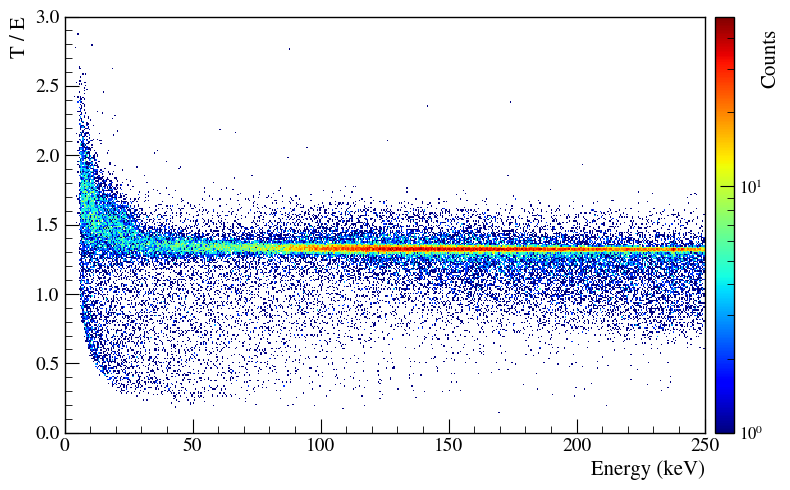

In [21]:
# T/E

#%matplotlib widget
fig, ax = plt.subplots(figsize=(8,5))
fig.canvas.header_visible = False

elo, ehi, epb = 0, 250, 0.5

toe = df_dsp['triE'] / df_dsp['energy_cal'] # not terrible psd, probably the best of these 3

# tlo, thi, tpb = toe.min(), toe.max(), 1 
tlo, thi, tpb = 0, 3, 0.01 # T/E
# tlo, thi, tpb = -1, 10, 0.1 # A_avg / E

print(toe.max(), toe.min())

# color the 0 values differently (they look weird all white)
# my_cmap = copy.copy(matplotlib.cm.get_cmap('jet')) # copy the default cmap
# my_cmap.set_bad((0,0,0))

_,_,_,img = plt.hist2d(df_dsp.energy_cal,
           toe,
           [int((ehi-elo)/epb), int((thi-tlo)/tpb)],
           range=[[elo, ehi], [tlo, thi]],
           norm=LogNorm(),
           cmap='jet')

# # # we could scale the histo z axis bins
# # # by exposure runtime and energy range (cts / (kev*kgd))
# # # note: (cts in each bin) / (keV per bin) = cts / keV
# # h_sc = h.copy()
# # # for cpd, idx in det_map.items():
# # #     h_sc[:,idx] /= exposure_det * xpb

plt.xlabel('Energy (keV)', ha='right', x=1)
plt.ylabel('T / E', ha='right', y=1)

# add a smart colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cb_ax = divider.append_axes('right', size='3%', pad=0.1)
cb = plt.colorbar(img, cax=cb_ax)
cb.ax.set_ylabel('Counts', labelpad=-2, y=0.9)
cb.ax.tick_params(labelsize=12)

plt.subplots_adjust(left=0.11, right=0.93, bottom=0.15)

plt.show()


/tmp/ipykernel_20151/1366215431.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _,_,_,img = plt.hist2d(df_dsp.energy_cal,
/tmp/ipykernel_20151/1366215431.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(img, cax=cb_ax)


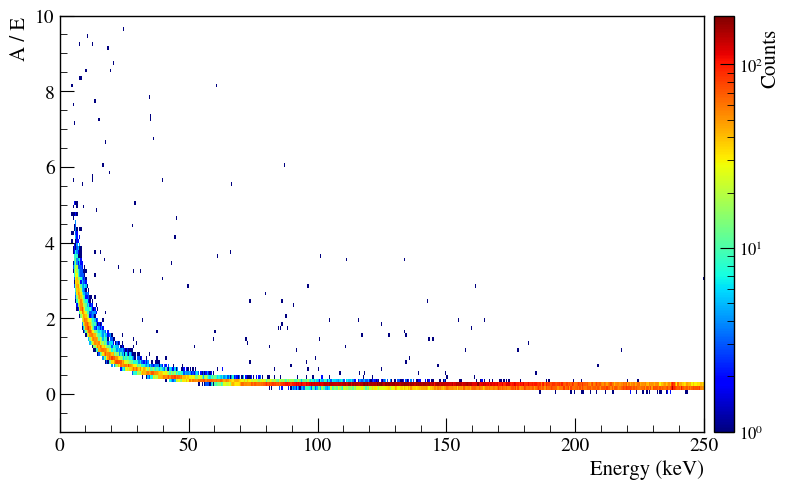

In [19]:
# A/E

#%matplotlib widget
fig, ax = plt.subplots(figsize=(8,5))
fig.canvas.header_visible = False

elo, ehi, epb = 0, 250, 0.5

# toe = df_dsp['A_gaus'] / df_dsp['energy_cal'] # useless w/ current tuning
toe = df_dsp['A_avg'] / df_dsp['energy_cal'] # better but doesn't get good psd

# tlo, thi, tpb = toe.min(), toe.max(), 1 
tlo, thi, tpb = -1, 10, 0.1 # A_avg / E

_,_,_,img = plt.hist2d(df_dsp.energy_cal,
           toe,
           [int((ehi-elo)/epb), int((thi-tlo)/tpb)],
           range=[[elo, ehi], [tlo, thi]],
           norm=LogNorm(),
           cmap='jet')

plt.xlabel('Energy (keV)', ha='right', x=1)
plt.ylabel('A / E', ha='right', y=1)

# add a smart colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cb_ax = divider.append_axes('right', size='3%', pad=0.1)
cb = plt.colorbar(img, cax=cb_ax)
cb.ax.set_ylabel('Counts', labelpad=-2, y=0.9)
cb.ax.tick_params(labelsize=12)

plt.subplots_adjust(left=0.11, right=0.93, bottom=0.15)

plt.show()


600.4584212124445 42710.0 -40810.0


/tmp/ipykernel_20151/770310378.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(df_dsp.energy_cal,
/tmp/ipykernel_20151/770310378.py:30: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(img, cax=cb_ax)


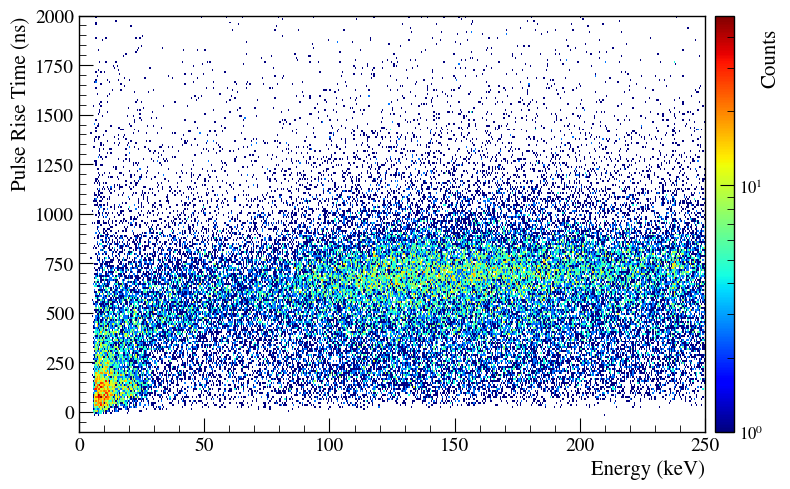

In [30]:
# Rise Time 0-20

#%matplotlib widget
fig, ax = plt.subplots(figsize=(8,5))
fig.canvas.header_visible = False

# risetime = df_dsp['tp_20'] - df_dsp['tp_0']
risetime = df_dsp['tp_20'] - df_dsp['tp_0']
print(risetime.mean(), risetime.max(), risetime.min())

elo, ehi, epb = 0, 250, 0.5

# ylo, yhi, ypb = risetime.min(), risetime.max(), 1
ylo, yhi, ypb = -100, 2000, 10

plt.hist2d(df_dsp.energy_cal,
           risetime,
           [int((ehi-elo)/epb), int((yhi-ylo)/ypb)],
           range=[[elo, ehi], [ylo, yhi]],
           norm=LogNorm(),
           cmap='jet')

plt.xlabel('Energy (keV)', ha='right', x=1)
plt.ylabel('Pulse Rise Time (ns)', ha='right', y=1)

# add a smart colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cb_ax = divider.append_axes('right', size='3%', pad=0.1)
cb = plt.colorbar(img, cax=cb_ax)
cb.ax.set_ylabel('Counts', labelpad=-2, y=0.9)
cb.ax.tick_params(labelsize=12)
plt.subplots_adjust(left=0.11, right=0.93, bottom=0.15)

plt.show()


In [12]:
df_dsp['pulse_risetime'] = df_dsp['tp_20'] - df_dsp['tp_0']
df_dsp.pulse_risetime.describe()

count    121853.000000
mean        600.458421
std        1000.811037
min      -40810.000000
25%         410.000000
50%         620.000000
75%         780.000000
max       42710.000000
Name: pulse_risetime, dtype: float64

In [11]:
prt_range = [50,100]
ecal_range = [9,12]

#getting the index from the box cut
data_idx = np.where((df_dsp['energy_cal'] > ecal_range[0]) & (df_dsp['energy_cal'] < ecal_range[1]) & (df_dsp['pulse_risetime']> prt_range[0]) & (df_dsp['pulse_risetime'] < prt_range[1]))[0]
print(len(data_idx))


#loading the raw file
import pygama.lgdo as lh5
raw_store = lh5.LH5Store()
tb_name = 'ORSIS3302DecoderForEnergy/raw'
lh5_dir = dg.lh5_dir
raw_list = lh5_dir + dg.fileDB['raw_path'] + '/' + dg.fileDB['raw_file']
f_raw = raw_list.values[0]
print(f_raw)

data_raw, nrows = raw_store.read_object(tb_name, f_raw, start_row=0, n_rows=data_idx[-1]+1)
bulk_wfs_all = (data_raw['waveform']['values']).nda
bulk_wfs = bulk_wfs_all[data_idx, :]
del bulk_wfs_all
ts = np.arange(0, bulk_wfs.shape[1], 1)
print(ts.shape)
print(bulk_wfs.shape)


#plotting the waveforms
#%matplotlib widget
plt.figure(figsize=(8,5))
#fig.canvas.header_visible = False

for i in range(bulk_wfs.shape[0]):
    plt.plot(ts, bulk_wfs[i,:])
plt.xlabel('Time (ns)', ha='right', x=1)
plt.ylabel('ADC', ha='right', y=1)

NameError: name 'df_dsp' is not defined

## Run 42: with 4 cycles each time
Because 4 cycles=2 hours ~ half-life of 83mKr (~1.83 hours)

In [7]:
krtscDB = DataGroup('/global/cfs/cdirs/legend/software/KrSTC/data/krstc.json', load=True)
runDB = krtscDB.runDB
lh5_dir = krtscDB.lh5_dir
dsp_list = lh5_dir + krtscDB.fileDB['dsp_path'] + '/' + krtscDB.fileDB['dsp_file']

beginning_cycle = 2019
beginning_cycle_42 = int(runDB['42'][0].split('-')[0])
end_cycle_42 = int(runDB['42'][0].split('-')[1])
cycles = np.arange(beginning_cycle_42, end_cycle_42+1, 4)
#print(cycles)

#dg = DataGroup('/global/homes/f/fnafis/krstc/krstc.json', load=True)
# lh5_dir = krtscDB.lh5_dir
# dsp_list = lh5_dir + krtscDB.fileDB['dsp_path'] + '/' + krtscDB.fileDB['dsp_file']

hit_list = dsp_list[beginning_cycle_42-beginning_cycle:end_cycle_42-beginning_cycle]


e_lit = [238, 1460]
e_uncal = [5.515e5, 3.3745e6]
poly_coeffs = np.polyfit(e_uncal, e_lit, 1) 
poly_func = np.poly1d(poly_coeffs)

binsize = 0.2 #keV
ecal_range = [0, 2000] #keV

skip_count = 0
for cycle in cycles[1:]:
    #print(cycle)
    skip_count += 1
    if not skip_count%2==0:
        #continue #skip this
        pass #nvm


    #print(cycle)
    hit_list = dsp_list[cycle-beginning_cycle-4:cycle-beginning_cycle]
    runtime = krtscDB.fileDB['runtime'][cycle-beginning_cycle-4:cycle-beginning_cycle].sum()
    print(runtime)
    if cycle==2699:
        runtime = krtscDB.fileDB['runtime'][cycle-beginning_cycle-3:cycle-beginning_cycle].sum()
        print('...', runtime)
    #print(runtime)
    #print(len(hit_list))
    df_hit = lh5.load_dfs(hit_list, ['energy'] ,'ORSIS3302DecoderForEnergy/dsp')

    # apply rough calibration to onboard energy
    
    df_hit['energy_cal'] = poly_func(df_hit['energy'])
    
    #get hist
    hist, bins, var = pgh.get_hist(df_hit['energy_cal'], bins=np.arange(*ecal_range, binsize), range=ecal_range)
    # normalize hist to counts/seconds/kev
    hist = hist/(runtime*60)/binsize
    #plot hist
    pgh.plot_hist(hist, bins, label='{}-{}'.format(cycle-4, cycle), lw=2)
    #plt.yscale('log')
    plt.xlabel('Energy (keV)', ha='right', x=1)
    plt.ylabel('Counts/sec/keV', ha='right', y=1)
    plt.title('Run 42 (decay run), without cyc2695') #stored as bkg in runDB
    #print(cycle, runtime, df_hit.shape, df_hit[(df_hit.energy_cal>0) & (df_hit.energy_cal<50)].shape)



# Bkg (run 40)
beginning_cycle_40 = int(runDB['40'][0].split('-')[0])
end_cycle_40 = int(runDB['40'][0].split('-')[1])
hit_list = dsp_list[beginning_cycle_40-beginning_cycle:end_cycle_40-beginning_cycle]
runtime = krtscDB.fileDB['runtime'][beginning_cycle_40-beginning_cycle:end_cycle_40-beginning_cycle].sum()
#print(runtime)
df_hit = lh5.load_dfs(hit_list, ['energy'] ,'ORSIS3302DecoderForEnergy/dsp')
df_hit['energy_cal'] = poly_func(df_hit['energy'])
print(df_hit.shape)

#get hist
hist, bins, var = pgh.get_hist(df_hit['energy_cal'], bins=np.arange(*ecal_range, binsize), range=ecal_range)
# normalize hist to counts/seconds
hist = hist/(runtime*60)
# convert hist to counts/sec/keV
hist = hist/binsize
#plot hist
pgh.plot_hist(hist, bins, lw=2, color='k', label='bkg (full run 40)')
    

plt.legend(loc=1)
plt.xlim(0,50)

# Conversion Electrons (CE): '-'
# Auger electrons (AE): '--'
# Gammas: ':'
# x-rays: '-.'
# expected_signals = [[32.23, '-', 0.63], 
# [12.65, ']]


KeyError: 'runtime'

(4238646, 4)
(4513928, 5)


Text(0.5, 1.0, 'Kr vs Bkg run example in Campaign 6')

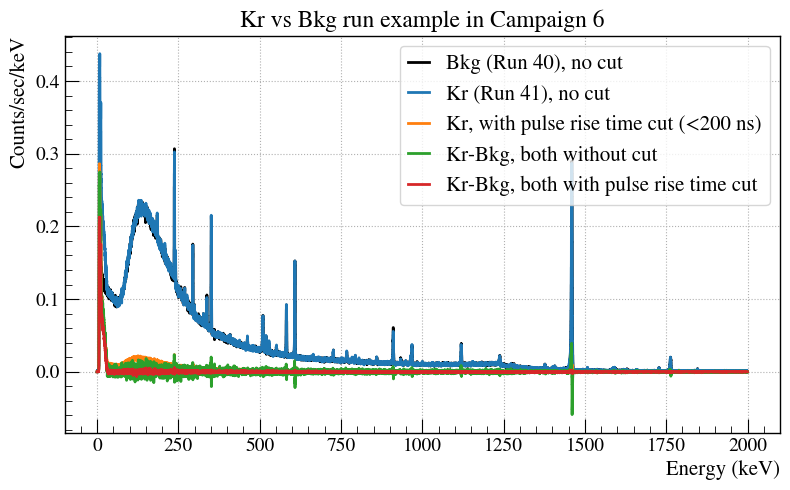

In [7]:
# Bkg (run 40)
#binsize = 0.1

beginning_cycle_40 = int(runDB['40'][0].split('-')[0])
end_cycle_40 = int(runDB['40'][0].split('-')[1])
hit_list = dsp_list[beginning_cycle_40-beginning_cycle:end_cycle_40-beginning_cycle]
runtime = krtscDB.fileDB['runtime'][beginning_cycle_40-beginning_cycle:end_cycle_40-beginning_cycle].sum()
#print(runtime)
df_hit = lh5.load_dfs(hit_list, ['energy','stp_20','tp_0'] ,'ORSIS3302DecoderForEnergy/dsp')
df_hit['energy_cal'] = poly_func(df_hit['energy'])
print(df_hit.shape)

#get hist
hist_bkg, bins_bkg, var_bkg = pgh.get_hist(df_hit['energy_cal'], bins=np.arange(*ecal_range, binsize), range=ecal_range)
# normalize hist to counts/seconds
hist_bkg = hist_bkg/(runtime*60)
# convert hist to counts/sec/keV
hist_bkg = hist_bkg/binsize
#plot hist
pgh.plot_hist(hist_bkg, bins_bkg, lw=2, color='k', label='Bkg (Run 40), no cut')


#bkg with the pulse rise time cut
df_hit['smoothened_pulse_rise_time'] = df_hit['stp_20'] - df_hit['tp_0']
h, b, v = pgh.get_hist(df_hit[df_hit.smoothened_pulse_rise_time<200]['energy_cal'], bins=np.arange(*ecal_range, binsize), range=ecal_range)
# normalize hist to counts/seconds
h = h/(runtime*60)
# convert hist to counts/sec/keV
h = h/binsize




# Kr (run 41)
beginning_cycle_41 = int(runDB['41'][0].split('-')[0])
end_cycle_41 = int(runDB['41'][0].split('-')[1])
hit_list = dsp_list[beginning_cycle_41-beginning_cycle:end_cycle_41-beginning_cycle]
runtime = krtscDB.fileDB['runtime'][beginning_cycle_41-beginning_cycle:end_cycle_41-beginning_cycle].sum()
#print(runtime)
df_hit = lh5.load_dfs(hit_list, ['energy', 'stp_20','tp_0'] ,'ORSIS3302DecoderForEnergy/dsp')
df_hit['energy_cal'] = poly_func(df_hit['energy'])
df_hit['smoothened_pulse_rise_time'] = df_hit['stp_20'] - df_hit['tp_0']
print(df_hit.shape)

#get hist
hist_kr, bins_kr, var_kr = pgh.get_hist(df_hit['energy_cal'], bins=np.arange(*ecal_range, binsize), range=ecal_range)
# normalize hist to counts/seconds
hist_kr = hist_kr/(runtime*60)
# convert hist to counts/sec/keV
hist_kr = hist_kr/binsize
#plot hist
pgh.plot_hist(hist_kr, bins_kr, lw=2, label='Kr (Run 41), no cut')


#get hist
hist, bins, var = pgh.get_hist(df_hit[df_hit.smoothened_pulse_rise_time<200]['energy_cal'], bins=np.arange(*ecal_range, binsize), range=ecal_range)
# normalize hist to counts/seconds
hist = hist/(runtime*60)
# convert hist to counts/sec/keV
hist = hist/binsize
#plot hist
pgh.plot_hist(hist, bins, lw=2, label='Kr, with pulse rise time cut (<200 ns)')
    

# kr-bkg without cut
hist_diff = hist_kr - hist_bkg
pgh.plot_hist(hist_diff, bins, lw=2, label='Kr-Bkg, both without cut')

# kr-bkg with cut
hist_diff_with_cut = hist - h
pgh.plot_hist(hist_diff_with_cut, bins, lw=2, label='Kr-Bkg, both with pulse rise time cut')



plt.legend(loc=1)
plt.xlim(0,50)
plt.xlabel('Energy (keV)', ha='right', x=1)
plt.ylabel('Counts/sec/keV', ha='right', y=1)
plt.title('Kr vs Bkg run example in Campaign 6') 

(-1.0, 50.0)

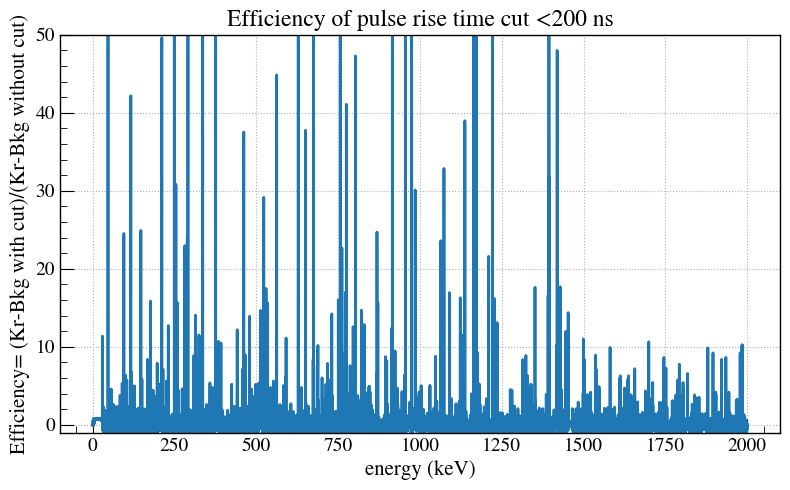

In [11]:
hist_eff = hist_diff_with_cut/hist_diff
pgh.plot_hist(hist_eff, bins, lw=2)
plt.xlabel('energy (keV)')
plt.ylabel('Efficiency= (Kr-Bkg with cut)/(Kr-Bkg without cut)')
plt.title('Efficiency of pulse rise time cut <200 ns')
plt.ylim(-1,50)
#plt.xlim(0,50)

(-1.0, 7.0)

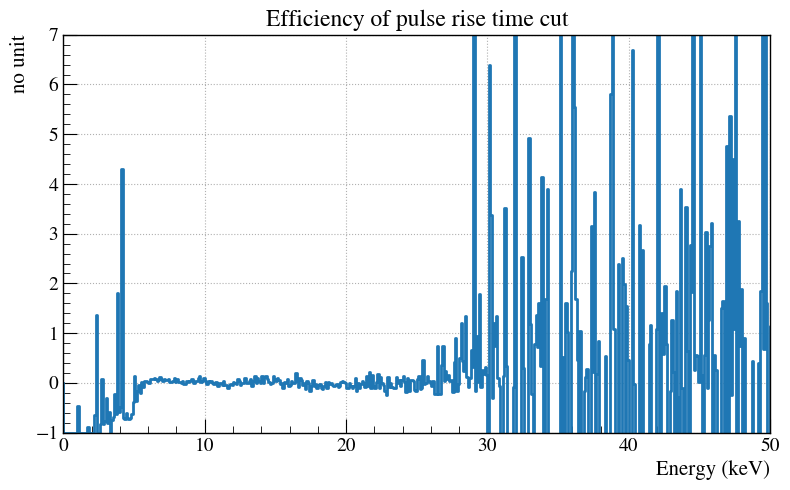

In [22]:
hist_eff = (hist-hist_diff)/hist_diff
pgh.plot_hist(hist_eff, bins, lw=2)
plt.xlim(0,50)
plt.xlabel('Energy (keV)', ha='right', x=1)
plt.ylabel('no unit', ha='right', y=1)
plt.title('Efficiency of pulse rise time cut') 
plt.ylim(-1,7)


## smoothened risetime vs energy_cal 2D histogram

In [6]:
beginning_cycle_41 = int(runDB['41'][0].split('-')[0])
end_cycle_41 = int(runDB['41'][0].split('-')[1])
print(beginning_cycle_41, end_cycle_41)

hit_list = dsp_list[beginning_cycle_41-beginning_cycle:end_cycle_41-beginning_cycle]

hit_list = dsp_list[2665-beginning_cycle]

# load the data
df_hit = lh5.load_dfs(hit_list, ['energy','tp_min', 'tp_0','tp_20', 'stp_20'] ,'ORSIS3302DecoderForEnergy/dsp')
df_hit['energy_cal'] = poly_func(df_hit['energy'])
df_hit['pulse_rise_time'] = df_hit['tp_20'] - df_hit['tp_0']

elo, ehi, epb = 0, 250, 0.5

# ylo, yhi, ypb = risetime.min(), risetime.max(), 1
ylo, yhi, ypb = -100, 2000, 10

plt.hist2d(df_hit.energy_cal,
           df_hit.pulse_rise_time,
           [int((ehi-elo)/epb), int((yhi-ylo)/ypb)],
           range=[[elo, ehi], [ylo, yhi]],
           norm = LogNorm(),
           cmap='jet')
# plot the colorbar
plt.colorbar()

plt.xlabel('Energy (keV)', ha='right', x=1)
plt.ylabel('Pulse Rise Time (ns)', ha='right', y=1)

2641 2678


NameError: name 'poly_func' is not defined

Test the normalized 2d hist with only run 41-2665.

0.01
0.007


/tmp/ipykernel_3771/582324406.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(xbins, ybins, hist, cmap=cmap, norm=LogNorm())
/tmp/ipykernel_3771/582324406.py:18: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


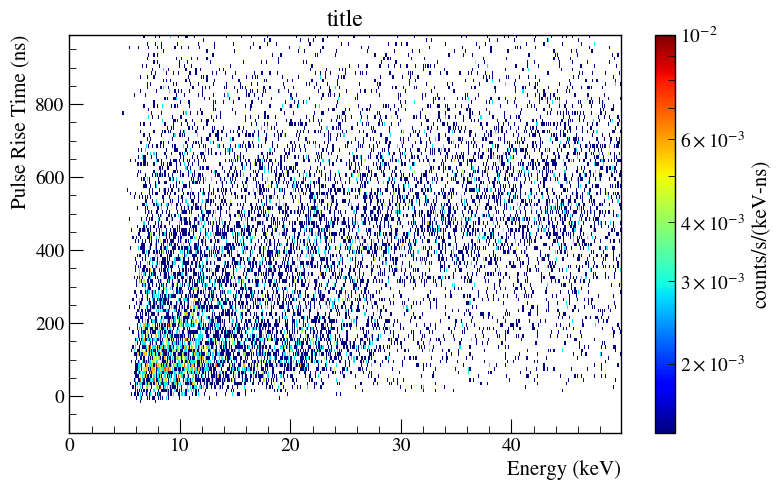

In [24]:
def normalized_hist2d(x, y, ranges, binsizes=[0.5, 0.1], runtime=1000, xlabel='energy_cal', ylabel='ylabel', title='title', cmap='jet', cbar_label='counts/s/(keV-ns)', vmax=None):

    bins = [np.arange(*ranges[0], binsizes[0]), np.arange(*ranges[1], binsizes[1])]

    hist, xbins, ybins = np.histogram2d(x, y, bins=bins, range=ranges)
    hist = hist.T
    # normalize to 1
    hist = hist / runtime/(binsizes[0]*binsizes[1])

    if vmax is not None:
        print(vmax)
        print(hist.max())
        hist = hist* (vmax/hist.max())

    # plot the results
    #plt.figure(figsize=(8,5)
    plt.pcolormesh(xbins, ybins, hist, cmap=cmap, norm=LogNorm())
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(cbar_label)
    plt.xlabel(xlabel, ha='right', x=1)
    plt.ylabel(ylabel, ha='right', y=1)
    plt.title(title)


    return hist, xbins, ybins
#--------------------------------------------------------------------#

# elo, ehi, epb = 0, 250, 0.5

# # ylo, yhi, ypb = risetime.min(), risetime.max(), 1
# ylo, yhi, ypb = -100, 2000, 10

x_range = [0, 50] #keV
x_binsize = 0.1 #keV

y_range = [-100, 1000] #ns
y_binsize = 10 #ns

a = normalized_hist2d(df_hit.energy_cal, df_hit.pulse_rise_time,[x_range, y_range], [x_binsize, y_binsize], xlabel='Energy (keV)', ylabel='Pulse Rise Time (ns)', title='title', vmax=0.01)

In [5]:
# get all the dsp files
krtscDB = DataGroup('/global/cfs/cdirs/legend/software/KrSTC/data/krstc.json', load=True)
runDB = krtscDB.runDB
lh5_dir = krtscDB.lh5_dir
dsp_list = lh5_dir + krtscDB.fileDB['dsp_path'] + '/' + krtscDB.fileDB['dsp_file']

beginning_cycle = 2019
beginning_cycle_41 = int(runDB['40'][0].split('-')[0])
end_cycle_41 = int(runDB['40'][0].split('-')[1])

hit_list = dsp_list[beginning_cycle_41-beginning_cycle:end_cycle_41-beginning_cycle+1] #+1 to include the last cycle, because runDB is last cycle INCLUSIVE

#hit_list = dsp_list[2665-2019:2665+3-2019]

# load the data
df_hit = lh5.load_dfs(hit_list, ['energy','tp_min', 'tp_0','tp_20', 'stp_20'] ,'ORSIS3302DecoderForEnergy/dsp')
df_hit['energy_cal'] = poly_func(df_hit['energy'])
df_hit['pulse_rise_time'] = df_hit['tp_20'] - df_hit['tp_0']
df_hit['smoothed_pulse_rise_time'] = df_hit['stp_20'] - df_hit['tp_0']

runtime = krtscDB.fileDB['runtime'][beginning_cycle_41-beginning_cycle:end_cycle_41-beginning_cycle].sum()*60 #in seconds

x_range = [0, 25] #keV
x_binsize = 0.05 #keV

y_range = [-10, 1000] #ns
y_binsize = 10 #ns

b = normalized_hist2d(df_hit.energy_cal, df_hit.pulse_rise_time,[x_range, y_range], [x_binsize, y_binsize], runtime=runtime, xlabel='Energy (keV)', ylabel='Pulse Rise Time (ns)', title='Run 41 (Kr)', cbar_label='counts/s/(keV-ns)', vmax=0.01)


NameError: name 'poly_func' is not defined

(0.0, 50.0)

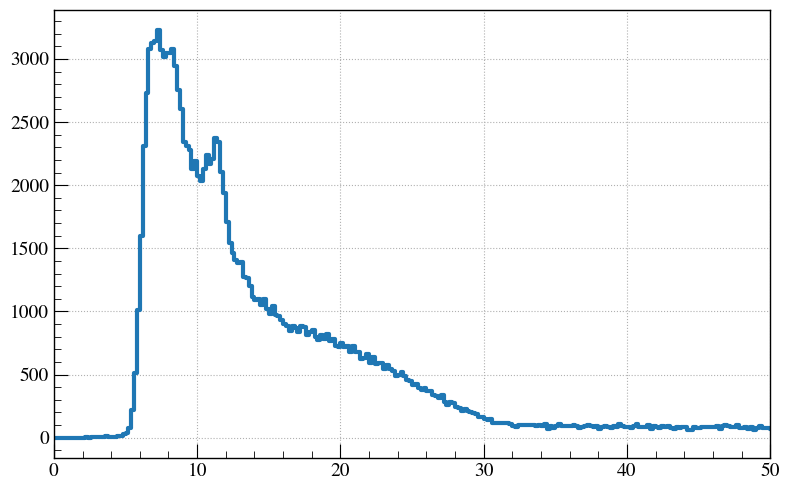

In [25]:
h, b, v = pgh.get_hist(df_hit[df_hit.smoothed_pulse_rise_time<160].energy_cal, bins = np.arange(0, 2000, 0.2))
pgh.plot_hist(h, b)
plt.xlim(0,50)

/tmp/ipykernel_47236/1854830266.py:8: RuntimeWarning: invalid value encountered in true_divide
  h = h1/h2


Text(0.5, 1.0, 'Fraction of events with smoothened pulse rise time <160 ns')

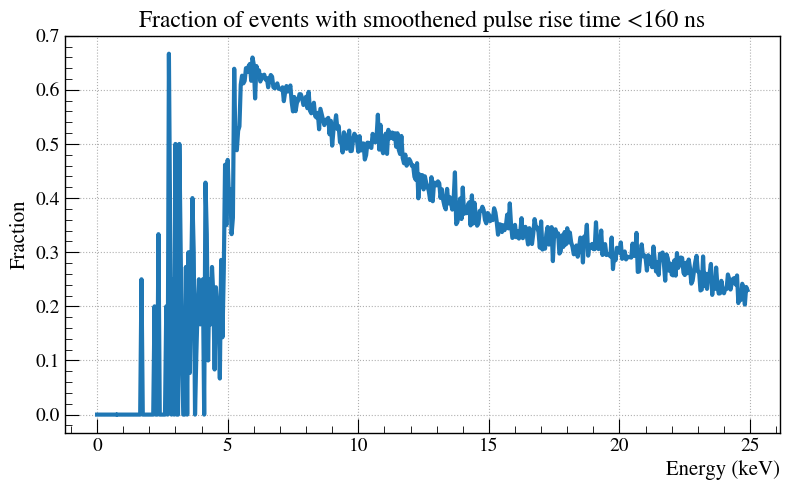

In [8]:
prt_lim = 160
ecal_range = [0, 25]
binsize = 0.05

h1, b1, v1 = pgh.get_hist(df_hit.energy_cal[df_hit.smoothed_pulse_rise_time<prt_lim], bins=np.arange(*ecal_range, binsize))
h2, b2, v2 = pgh.get_hist(df_hit.energy_cal, bins=np.arange(*ecal_range, binsize))

h = h1/h2
b = b1[:-1]

plt.plot(b, h)
plt.xlabel('Energy (keV)', ha='right', x=1)
plt.ylabel('Fraction')
plt.title('Fraction of events with smoothened pulse rise time <'+str(prt_lim)+' ns')

/tmp/ipykernel_3771/2474010241.py:4: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(a[1], a[2], hist_diff, cmap='jet')
/tmp/ipykernel_3771/2474010241.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar()


Text(0.5, 1.0, 'Bkg (run40) subtracted from Kr run (run41)')

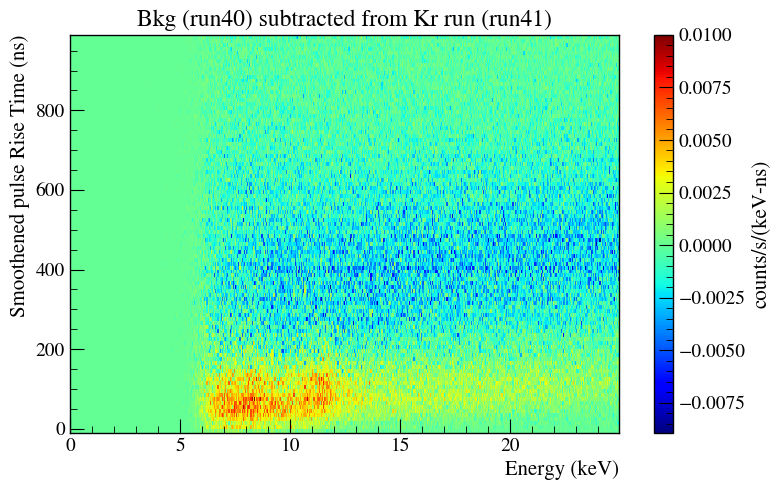

In [29]:
vmax = 0.01
hist_diff = a[0]-b[0]
hist_diff = hist_diff * (vmax/hist_diff.max())
plt.pcolormesh(a[1], a[2], hist_diff, cmap='jet')
cbar = plt.colorbar()
cbar.ax.set_ylabel('counts/s/(keV-ns)')
plt.xlabel('Energy (keV)', ha='right', x=1)
plt.ylabel('Smoothened pulse Rise Time (ns)', ha='right', y=1)
plt.title('Bkg (run40) subtracted from Kr run (run41)')

['/global/u2/f/fnafis/uw_visit', '', '/opt/mods/lib/python3.6/site-packages', '/opt/root/lib', '/global/u2/f/fnafis/uw_visit', '/opt/anaconda3/lib/python39.zip', '/opt/anaconda3/lib/python3.9', '/opt/anaconda3/lib/python3.9/lib-dynload', '/global/homes/f/fnafis/.local/lib/python3.9/site-packages', '/global/u2/f/fnafis/pygama', '/global/u2/f/fnafis/pygama/src', '/opt/anaconda3/lib/python3.9/site-packages', '/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions', '/global/u2/f/fnafis/.ipython', '/global/homes/f/fnafis/utils_nf']
0.1
0.0954


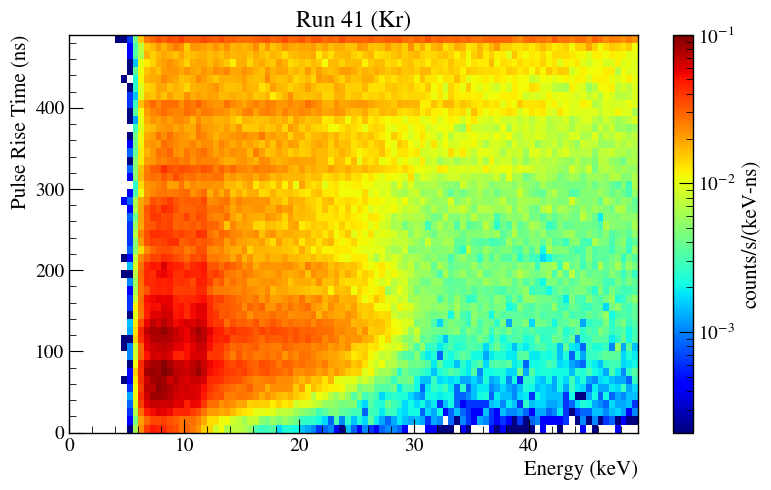

In [24]:
import sys
filename = '/global/homes/f/fnafis/utils_nf'
if filename not in sys.path:
    sys.path.append(filename)
print(sys.path)
import math_nf as mf


x = mf.normalized_hist2d(df_hit.energy_cal, df_hit.pulse_rise_time,[[0,50],[0,500]], [0.5, 10], runtime=1000, xlabel='Energy (keV)', ylabel='Pulse Rise Time (ns)', title='Run 41 (Kr)', cbar_label='counts/s/(keV-ns)', vmax=0.1)

,energy,tp_min,tp_0,tp_20,stp_20,energy_cal,pulse_rise_time,smoothed_pulse_rise_time
0,999272,18340.0,39420.0,40030.0,40000.0,431.828333,610.0,580.0
1,1023862,16550.0,39400.0,39970.0,39950.0,442.472676,570.0,550.0
2,1323811,36580.0,39490.0,40060.0,40040.0,572.312448,570.0,550.0
3,751276,2660.0,39230.0,40000.0,39970.0,324.477603,770.0,740.0
4,552569,8540.0,39240.0,39930.0,39920.0,238.462741,690.0,680.0
...,...,...,...,...,...,...,...,...
4520126,980899,33200.0,39230.0,40040.0,40020.0,423.875160,810.0,790.0
4520127,643513,7060.0,39320.0,39960.0,39940.0,277.829928,640.0,620.0
4520128,351496,1400.0,39160.0,39890.0,39860.0,151.423702,730.0,700.0
4520129,1484050,33900.0,39590.0,40090.0,40060.0,641.675558,500.0,470.0


## superpulse

'/global/cfs/cdirs/m2676/data/krstc/LH5/raw/krstc_run41_cyc2665_raw.lh5'

In [103]:
dsp_filename = dsp_list[2665-2019]
raw_filename = dsp_filename.replace('dsp', 'raw')
print(raw_filename)
box_cut = [[8, 10], [20, 80]]
df_hit = lh5.load_dfs(dsp_filename, ['energy','stp_20', 'tp_0', 'tp_50'] ,'ORSIS3302DecoderForEnergy/dsp')
df_hit['energy_cal'] = poly_func(df_hit['energy'])
df_hit['smoothed_pulse_rise_time'] = df_hit['stp_20'] - df_hit['tp_0']
indices = df_hit[(df_hit.energy_cal>box_cut[0][0]) & (df_hit.energy_cal<box_cut[0][1]) & (df_hit.smoothed_pulse_rise_time>box_cut[1][0]) & (df_hit.smoothed_pulse_rise_time<box_cut[1][1])].index
df_hit['tp_50'][indices.values]

/global/cfs/cdirs/m2676/data/krstc/LH5/raw/krstc_run41_cyc2665_raw.lh5


747       38470.0
1042      38770.0
1450      38770.0
1554      41980.0
2103      43050.0
           ...   
117523    39050.0
118173    38880.0
118747    38600.0
120511    40500.0
121032    39160.0
Name: tp_50, Length: 218, dtype: float64

Text(0, 0.5, 'daq energy')

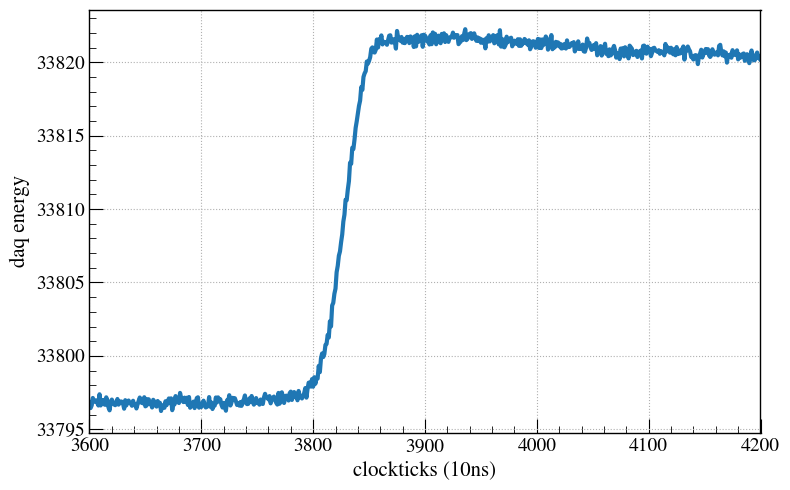

In [39]:

table_name='ORSIS3302DecoderForEnergy'
with h5py.File(raw_filename, 'r') as f:    
        wfs = f[table_name]['raw']['waveform']['values'][indices.values]
superpulse_kr = np.mean(wfs, axis=0)
plt.plot(superpulse_kr)
plt.xlim(3600, 4200)
plt.xlabel('clockticks (10ns)')
plt.ylabel('daq energy')
#plt.title('Kr (run 41, cycle 2665)')

(3600.0, 4200.0)

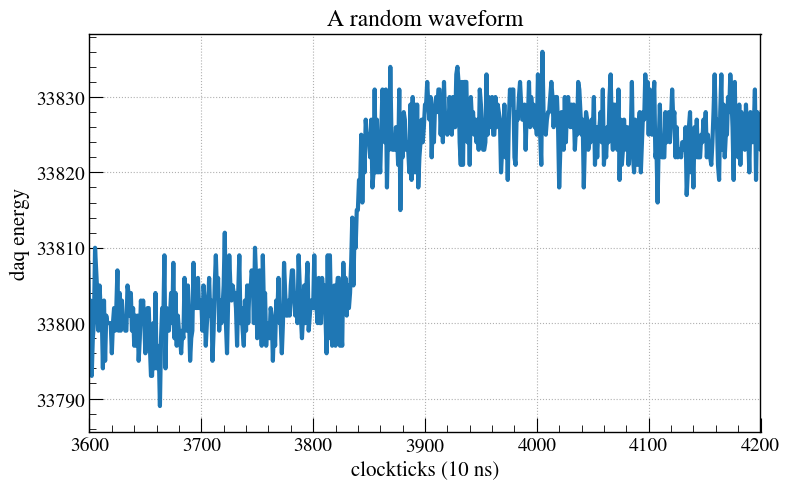

In [40]:
plt.plot(wfs[5])
#plt.plot(wfs[50])
plt.xlabel('clockticks (10 ns)')
plt.ylabel('daq energy')
plt.title('A random waveform')
plt.xlim(3600,4200)

In [42]:
from scipy.ndimage import gaussian_filter1d

Text(0.5, 1.0, 'a random waveform with gaussian filter')

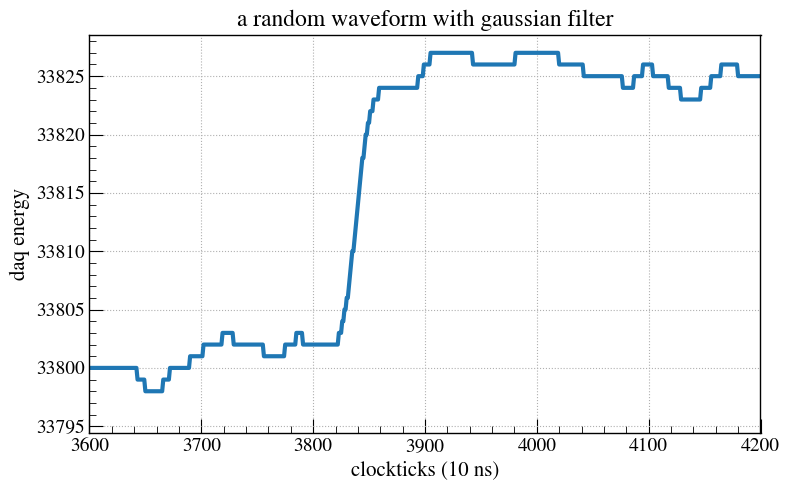

In [50]:
wff = gaussian_filter1d(wfs[5], sigma = 8)
plt.plot(wff)
plt.xlim(3600,4200)
plt.xlabel('clockticks (10 ns)')
plt.ylabel('daq energy')
plt.title('a random waveform with gaussian filter')

In [146]:
dsp_filename = dsp_list[2630-2019]
raw_filename = dsp_filename.replace('dsp', 'raw')
print(raw_filename)
box_cut = [[8, 10], [20, 80]]
df_hit = lh5.load_dfs(dsp_filename, ['energy','stp_20', 'tp_0', 'tp_50'] ,'ORSIS3302DecoderForEnergy/dsp')
df_hit['energy_cal'] = poly_func(df_hit['energy'])
df_hit['smoothed_pulse_rise_time'] = df_hit['stp_20'] - df_hit['tp_0']
indices = df_hit[(df_hit.energy_cal>box_cut[0][0]) & (df_hit.energy_cal<box_cut[0][1]) & (df_hit.smoothed_pulse_rise_time>box_cut[1][0]) & (df_hit.smoothed_pulse_rise_time<box_cut[1][1])].index
table_name='ORSIS3302DecoderForEnergy'
with h5py.File(raw_filename, 'r') as f:    
        wfs = f[table_name]['raw']['waveform']['values'][indices.values]
superpulse_bkg = np.mean(wfs, axis=0)

/global/cfs/cdirs/m2676/data/krstc/LH5/raw/krstc_run40_cyc2630_raw.lh5


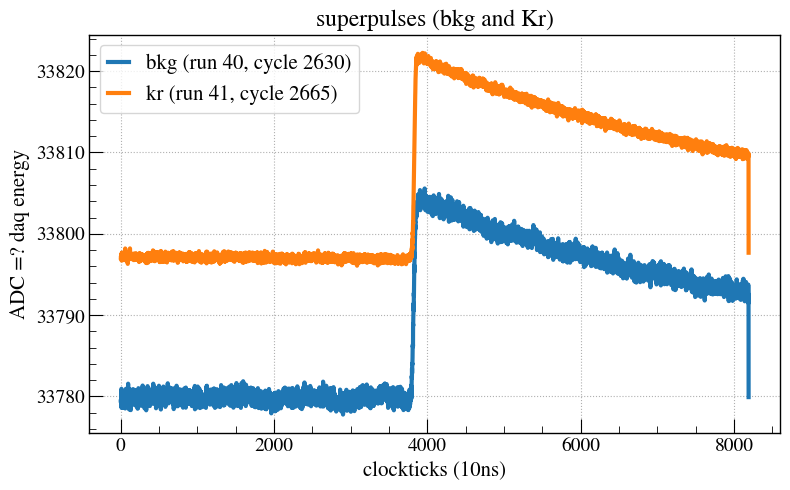

In [84]:
plt.plot(superpulse_bkg, label='bkg (run 40, cycle 2630)')
plt.plot(superpulse_kr, label='kr (run 41, cycle 2665)')
#plt.xlim(3600, 4200)
plt.xlabel('clockticks (10ns)')
plt.ylabel('ADC =? daq energy')
plt.title('superpulses (bkg and Kr)')
plt.legend()

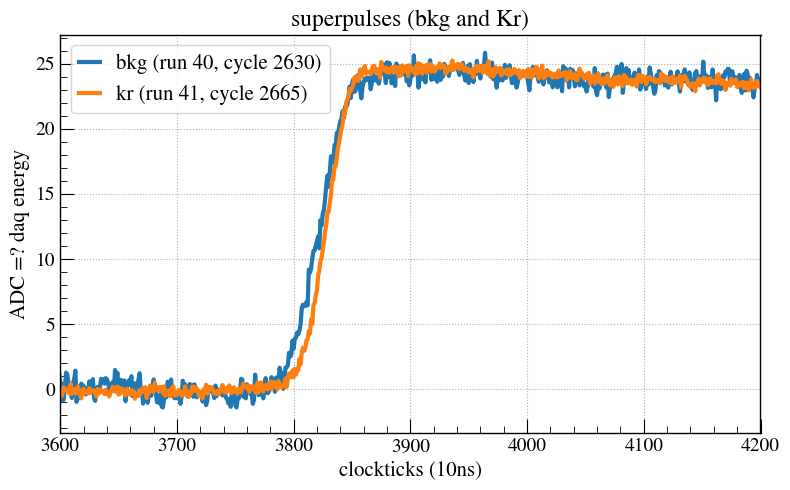

In [85]:
#baseline subtraction
bkg_baseline = np.mean(superpulse_bkg[2000:3000])
kr_baseline = np.mean(superpulse_kr[2000:3000])
superpulse_bkg = superpulse_bkg - bkg_baseline
superpulse_kr = superpulse_kr - kr_baseline

plt.plot(superpulse_bkg, label='bkg (run 40, cycle 2630)')
plt.plot(superpulse_kr, label='kr (run 41, cycle 2665)')
plt.xlim(3600, 4200)
plt.xlabel('clockticks (10ns)')
plt.ylabel('ADC =? daq energy')
plt.title('superpulses (bkg and Kr)')
plt.legend()

In [28]:
import sys
utils_path = '/global/homes/f/fnafis/utils_nf/'
if utils_path not in sys.path:
    sys.path.append(utils_path)
import legend_utils_nf as lutils

/global/cfs/cdirs/m2676/data/krstc/LH5/raw/krstc_run42_cyc2679_raw.lh5


(3, 8192)

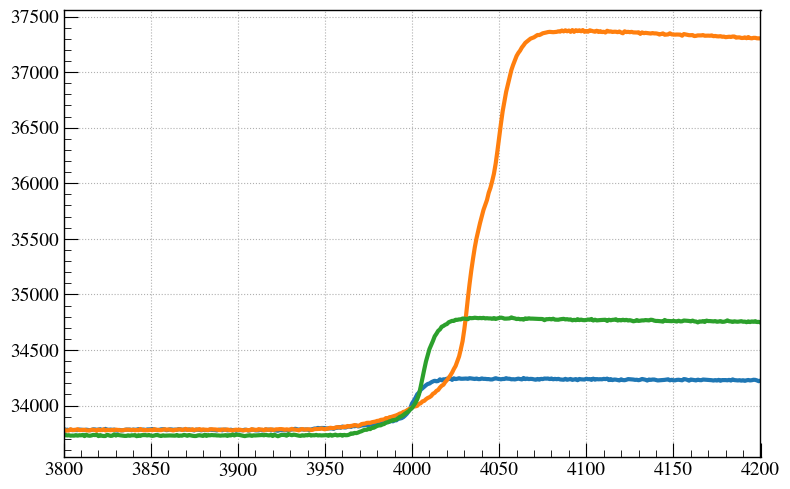

In [62]:
raw_filename = hit_list.iloc[0].replace('dsp', 'raw')
print(raw_filename)

with h5py.File(raw_filename, 'r') as f:    
        wfs2 = f['ORSIS3302DecoderForEnergy']['raw']['waveform']['values'][[0,1,2]]
for wf in wfs:
        plt.plot(wf)
plt.xlim(3800,4200)
wfs2.shape

In [8]:
beginning_cycle_40 = int(runDB['40'][0].split('-')[0])
end_cycle_40 = int(runDB['40'][0].split('-')[1])
hit_list = dsp_list[beginning_cycle_40-beginning_cycle:end_cycle_40-beginning_cycle]

df_hit = lh5.load_dfs(hit_list, ['energy'] ,'ORSIS3302DecoderForEnergy/dsp')
df_hit['energy_cal'] = poly_func(df_hit['energy'])
df_hit

,energy,energy_cal
0,0,-0.729366
1,0,-0.729366
2,0,-0.729366
3,0,-0.729366
4,0,-0.729366
...,...,...
4238641,3363356,1455.176065
4238642,1528808,661.050080
4238643,379277,163.449343
4238644,361204,155.626032


In [9]:
dsp_filename = hit_list.iloc[5]
print(dsp_filename)
raw_filename = dsp_filename.replace('dsp', 'raw')
df_hit = lh5.load_dfs(dsp_filename, ['energy','stp_20', 'tp_0', 'tp_50'] ,'ORSIS3302DecoderForEnergy/dsp')
df_hit['energy_cal'] = poly_func(df_hit['energy'])
df_hit['smoothed_pulse_rise_time'] = df_hit['stp_20'] - df_hit['tp_0']

box_cut = [[8, 10], [20, 80]]

indices = df_hit[(df_hit.energy_cal>box_cut[0][0]) & (df_hit.energy_cal<box_cut[0][1]) & (df_hit.smoothed_pulse_rise_time>box_cut[1][0]) & (df_hit.smoothed_pulse_rise_time<box_cut[1][1])].index.values
indices.shape

/global/cfs/cdirs/m2676/data/krstc/LH5/dsp/krstc_run40_cyc2609_dsp.lh5


(31,)

array([  1655,  13970,  18307, ..., 105402, 111389, 121848])

In [39]:
time = lutils.get_time_axis()
time

0           0
1          10
2          20
3          30
4          40
        ...  
8187    81870
8188    81880
8189    81890
8190    81900
8191    81910
Length: 8192, dtype: int64

In [42]:
tp50s = df_hit['tp_50'][indices]
tps

array([4657, 4925, 4004, 4063, 3987])

Unit: ADC


(8192,)

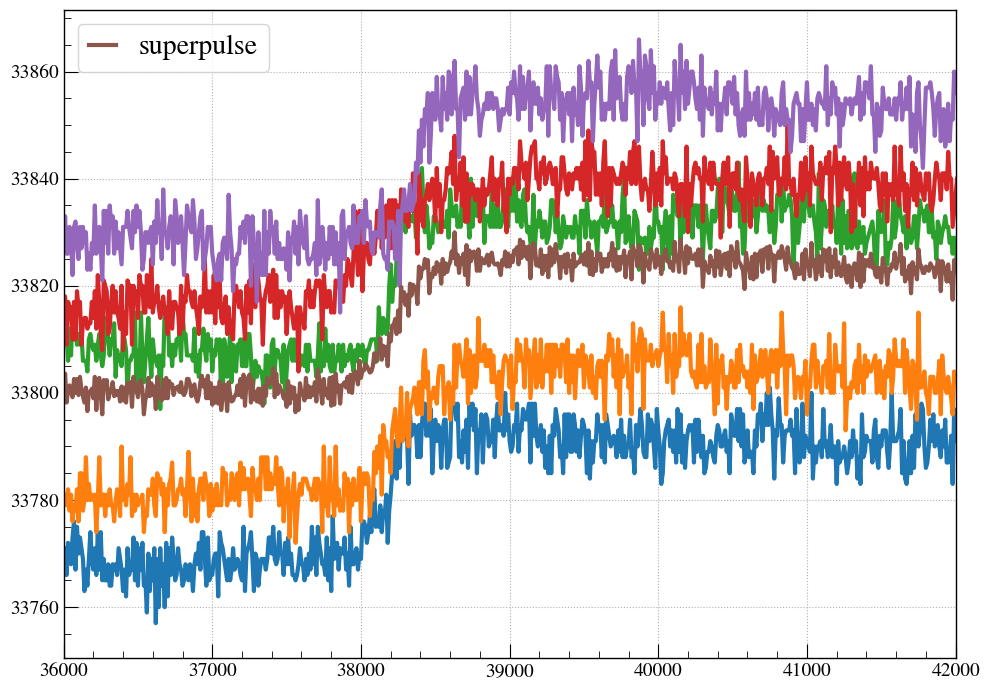

In [41]:
ind = indices[0:5]
lwfs = lutils.get_raw_wfs(raw_filename, indices=ind, plot=True).raw_waveforms

# convert each lwf in lwfs to numpy array
wfs = np.array([np.array(lwf) for lwf in lwfs])

# calculate the superpulse
superpulse = np.mean(wfs, axis=0)
plt.plot(time, superpulse, label='superpulse')
plt.xlim(36000, 42000)
plt.legend()
superpulse.shape

/global/cfs/cdirs/m2676/data/krstc/LH5/raw/krstc_run40_cyc2609_raw.lh5
(31, 8192)


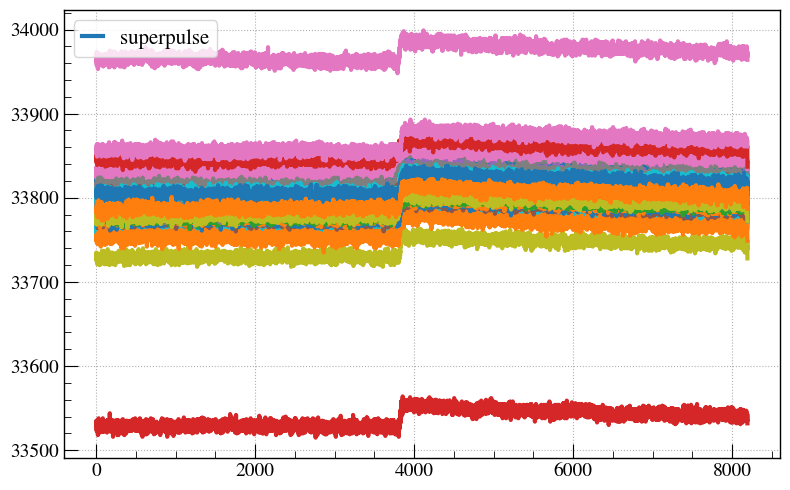

In [10]:

def get_superpulse(raw_filename, indices, tp50s, midpoint = 4000, plot=False):

    print(raw_filename)

    with h5py.File(raw_filename, 'r') as f:
        wfs = f['ORSIS3302DecoderForEnergy']['raw']['waveform']['values'][indices]
    shifted_wfs = np.array([np.roll(wf, midpoint - tp50) for wf, tp50 in zip(wfs, tp50s)])
    print(shifted_wfs.shape)
    superpulse = np.mean(shifted_wfs, axis=0)
    if plot:
        plt.plot(superpulse, label='superpulse')
        for wf in wfs:
            plt.plot(wf)
    return superpulse

tp50s = (df_hit['tp_50'][indices].values/10).astype(int)
get_superpulse(raw_filename, indices, tp50s, midpoint = 4000, plot=True)
#plt.xlim(3800, 4200)
plt.legend()
    

In [53]:
indices

array([  1655,  13970,  18307, ..., 105402, 111389, 121848])

In [60]:
df_hit = lh5.load_dfs(dsp_filename, ['energy','trapEmax','stp_20', 'tp_0', 'tp_50'] ,'ORSIS3302DecoderForEnergy/dsp')
# extract the rows that match with indices
df_hit = df_hit.iloc[indices].iloc[0:5]
df_hit

,energy,trapEmax,stp_20,tp_0,tp_50
1655,20986,22.121698,38050.0,38000.0,46570.0
13970,22369,23.944817,38070.0,38020.0,49250.0
18307,23141,24.814562,38120.0,38070.0,40040.0
19484,21631,23.486002,37890.0,37830.0,40630.0
23056,23297,25.027670,38310.0,38270.0,39870.0


In [65]:
raw_filename

'/global/cfs/cdirs/m2676/data/krstc/LH5/raw/krstc_run40_cyc2609_raw.lh5'

[ 1655 13970 18307 19484 23056]


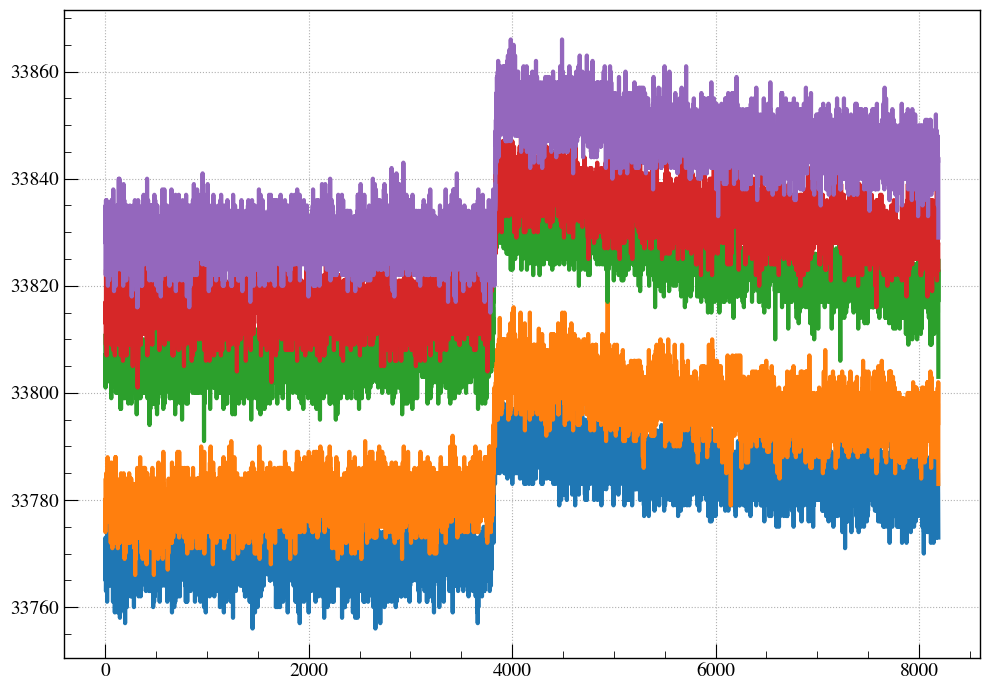

In [64]:
with h5py.File(raw_filename, 'r') as f:
    wfs = f['ORSIS3302DecoderForEnergy']['raw']['waveform']['values'][indices[0:5]]
print(indices[0:5])
for wf in wfs:
    plt.plot(wf)